In [68]:
%matplotlib inline
import matplotlib.pylab as plt
import networkx as nx           # 'pip install networkx'
import json
from collections import Counter
import community                # 'pip install python-louvain' or 'conda install -c auto python-louvain'
import pandas as pd
import numpy as np

In [ ]:
# Ex. 10.1.1: The method described above works for anything you might want to measure in a network. Let's say, instead of 
# measuring the number of triangles, you measured the network diameter. Explain in your own words how to assess the statistical 
# significance (the p-value) of such a measurement, using the same null model.

# to assess wheter the observed network diameter is statistical significant different from a null model, where the links where
# randomly distributed we apply the described simulation procedure. For each simulation we obtain a random network and 
# calculate the diameter of each network. Given the simulated diameters we can calculate the probability of realizing the
# the observed diameter given our null hypothesis of random network. This probability is given by the fraction of simulated
# diameters that are equal to or greater than the observed diameter.

In [ ]:
# Ex. 10.1.2: The null model described above rewires a network while preserving the degree distribution. Here is implementation 
# of it in NetworkX. In your own words, describe:

# 1. How it works and why it achieves randomness without changing the degree distribution.
# 2. Also describe what can sometimes happen and why the desired number of swaps nswaps is only an upper-bound on the number of 
# swaps.

# the double_edge_swap procedure changes nswap*2 links randomely. Since the new links are randomely set there is a positive 
# probability that some of the new links are identical to some of the links in the original network.

In [96]:
# Ex. 10.1.3: Load the Facebook wall-post network from last week, into a networkx.Graph object called G.

data = pd.read_csv(
    'facebook-wall.txt.gz', 
    compression='gzip',
    delimiter="\t",
    header=None,
    names=['user1', 'user2', 'timestamp'], 
    sep=' ', quotechar='"', error_bad_lines=False)



def SliceDiGraph(data,t0,t1):
    # Subset of the pandas dataframe
    data_t = data.loc[data.timestamp.between(t0, t1)]

    # Count the number of times each link occurs and store that in a new 'weight' column
    data_t = data_t.groupby(['user1', 'user2']).size().reset_index(name='weight')

    # Create a `nx.DiGraph` from this dataframe
    G_t = nx.from_pandas_edgelist(data_t, 'user1', 'user2', 'weight', create_using=nx.DiGraph)
    return G_t

t0 = data.timestamp.min() # Lower bound of time-slice (here: 365 days before last wall post)
t1 = data.timestamp.max() # Lower bound of time-slice

G0 = SliceDiGraph(data,t0,t1)

# double_edge_swap can only handle undirected network. Hence, I transform network from directed network to undirected network:
G = G0.to_undirected() 
# Note that this is major change of the original data and changes the interpretation of the network.

In [97]:
# 1. Measure the average local clustering coefficient (ALCC) of G. Print it.
# 2. Over 1000 iterations, measure the ALCC for G where, in each iteration, you have made 1000 edge swaps using double_edge_swap. 
# Append the measured ALCC values to a list. Print the average of this list. *Note: this will obviously take some time**.
# 3. Report the p-value of your result, the ALCC of the real data.
# 4. Make a histogram that displays the distribution of ALCC values in the null models as a histogram as well as the ALCC of the 
# real data as a vertical line. Comment on this result. Does it make sense?

ALCC_G = nx.average_clustering(G, nodes=None, weight=None, count_zeros=True)
print('1. ALCC =',ALCC_G)

N=1000
ALCC_H = np.zeros(N)

for i in range(0, N):
    H = nx.double_edge_swap(G, nswap=1000, max_tries=10000)
    ALCC_H[i] = nx.average_clustering(H, nodes=None, weight=None, count_zeros=True)
    
A = np.mean(ALCC_H)
print('2. Average mean ALCC =', A)


1. ALCC = 0.10796398386235195
2. Average mean ALCC = 0.0043701560697643645


p-value = pr(ALCC>=0.1079|H_0) = 0.0
number of simulated networks with ALCC>=0.1079:  0
max simulated ALCC:  0.10451280521997783


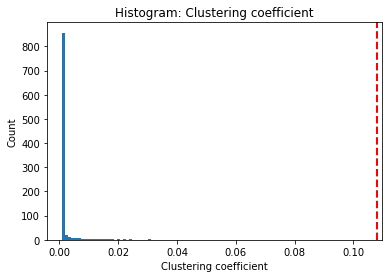

In [112]:
dum = (ALCC_H>=ALCC_G) 
pval = np.sum(dum)/N
print('p-value = pr(ALCC>=0.1079|H_0) =',pval)
print('number of simulated networks with ALCC>=0.1079: ',np.sum(dum))
print('max simulated ALCC: ',np.max(ALCC_H))
# None of the simulated networks results in an ALCC greater or equal to 0.1079. Hence, the resulting p-value is 0.0

plt.plot()

plt.title("Histogram: Clustering coefficient")
plt.ylabel("Count")
plt.xlabel("Clustering coefficient")

plt.hist(ALCC_H,bins=100)
plt.axvline(x=ALCC_G, color='r', linestyle='dashed', linewidth=2)
# The simulated networks have all an ALCC close to zero.

In [ ]:
# Ex. 10.2.1:

# 1.: i and j refers to column and row of the adjacency matrix, A, respectively. Hence, i and j refers to two nodes of the
# network.

# 2.: the delta function tells us whether node i and node j belongs to the same modules. Hence, the delta function is
# just an identicator function that equals one if i and j belongs to the same modules.

# 3.: k_i*k_j/(2m) is the expected number of links between node i and node j if the nodes are randomely linked. Hence, the
# the null model is that the links are randomely set.

# 4.: by including the delta function we implicitly count how many links fall within a given group and not just how many links
# there exists between any nodes.

# 5.: if we sum over the degree for each node this equal to two time the total number of links (2*m). Hence, this normalization 
# ensures that Q<=1.

# 6.: Modularity is the fraction of the links that fall within the given group minus the expected fraction if the links
# were distributed at random. It is positive if the number of links within groups exceeds the number of expected on the basis  
# of chance.

In [138]:
A = np.array([
    [0, 1, 1, 0, 0, 0],
    [1, 0, 1, 0, 0, 0],
    [1, 1, 0, 1, 0, 0],
    [0, 0, 1, 0, 1, 1],
    [0, 0, 0, 1, 0, 1],
    [0, 0, 0, 1, 1, 0],
])

c = [0, 0, 0, 0, 1, 1]

In [139]:
def modularity(A, c):
    """Compute modularity for a labeled network.
    
    Input
    -----
        A : numpy.array
            Adjacency matrix. (N, N) square matrix.
        c : list of ints
            Community labels. Length N.
    
    Output
    ------
        out : float
    """
    [N, M] = A.shape # Dimensions of A (N=M)

    u1 = np.ones(N) # unit row vector
    u2 = np.ones((N,1)) # unit column vector

    k = u1.dot(A) # Vector containing the degree of each node
    m = k.dot(u2) # Number of links
    
    L = 0
    for i in range(0, N):
        for j in range(0, N):
            delta = (c[i]==c[j]) # delta function
            L = (A[i,j] - (k[i]*k[j])/(2*m)) * delta + L
        
        
    Q = (1/(2*m)) * L  # modularity of the graph      
    return Q

In [140]:
Q = modularity(A, c)
print(Q)

[0.20918367]


In [141]:
c_opt = [0, 0, 0, 1, 1, 1]
Q_opt = modularity(A, c_opt)
print(Q_opt)

[0.30357143]
